# **MOVIE GENRE CLASSIFICATION**
## by: Juan Carlos Eraso & Jonh Calvo

---



# **PREPARING COLAB **

In [1]:
!pip install tqdm livelossplot kaggle
!pip install --user kaggle
!pip install pydo

    100% |████████████████████████████████| 51kB 2.0MB/s 
    100% |████████████████████████████████| 51kB 4.8MB/s 
  Running setup.py bdist_wheel for livelossplot ... - \ done
  Stored in directory: /content/.cache/pip/wheels/67/8b/e9/3990164e3b2a421145b9d9d76fc8aa889225d495b043faeb73
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /content/.cache/pip/wheels/3b/8e/14/adcbb71d126f5fb939fec8aa81394450922c20eee876bf8882
Successfully built livelossplot kaggle


You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 378kB 4.9MB/s 
    Complete output from command python setup.py egg_info:
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/tmp/pip-install-arfdfg_g/pydo/setup.py", line 1, in <module>
        import ez_setup
      File "/tmp/pip-install-arfdfg_g/pydo/ez_setup/__init__.py", line 91
        except pkg_resources.VersionConflict, e:
                                            ^
    SyntaxError: invalid syntax
    
    ----------------------------------------
Command "python setup.py egg_info" failed with error code 1 in /tmp/pip-install-arfdfg_g/pydo/
You are using pip version 10.0.1, however version 18.0 is available.

In [2]:
#UPLOAD DE KAGGLE API FILE (TOKEN)
#this is necesary for downloading the competition files

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"juanchokaggle","key":"fa7aa04de1e143a64357424c74b7bec7"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /content/.kaggle/kaggle.json

In [4]:
#IMPORT IMPORTANT PACKAGES
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tqdm import tqdm
import os,zipfile
%matplotlib inline

from keras.layers.convolutional import Conv2D
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPooling2D
from keras.optimizers import SGD,RMSprop,Adam
from livelossplot import PlotLossesKeras
from keras.callbacks import History

Using TensorFlow backend.


In [5]:
#IMPORT IMPORTANT PACKAGES

#AFTER RUNINGS, THERE WILL BE AN ERROR THAT DOES NOT AFFECT IN ANY WAY

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

IndexError: ignored

## Download and read data from Kaggle to CoLab 

### Download and UnZip

In [6]:
!kaggle competitions download -c miia4406-movie-genre-classification

  0%|                                               | 0.00/2.51M [00:00<?, ?B/s]
100%|███████████████████████████████████████| 2.51M/2.51M [00:00<00:00, 113MB/s]
  0%|                                               | 0.00/6.13M [00:00<?, ?B/s]
100%|██████████████████████████████████████| 6.13M/6.13M [00:00<00:00, 80.6MB/s]
 84%|████████████████████████████████▊      | 94.0M/112M [00:00<00:00, 96.1MB/s]
100%|█████████████████████████████████████████| 112M/112M [00:00<00:00, 149MB/s]
 43%|████████████████▎                     | 1.66G/3.85G [00:21<01:19, 29.6MB/s]

100%|█████████████████████████████████████▉| 3.85G/3.85G [01:59<00:00, 21.3MB/s]
100%|██████████████████████████████████████| 3.85G/3.85G [01:59<00:00, 34.7MB/s]


In [0]:
dataTraining = pd.read_csv('/content/.kaggle/competitions/miia4406-movie-genre-classification/dataTraining.csv', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('/content/.kaggle/competitions/miia4406-movie-genre-classification/dataTesting.csv', encoding='UTF-8', index_col=0)

In [8]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [9]:
dataTraining.index

Int64Index([ 3107,   900,  6724,  4704,  2582,  9784,  8804,  3501,  7145,
             4067,
            ...
             8268,  3313,  4781,  6632, 10794,  8417,  1592,  1723,  7605,
              215],
           dtype='int64', length=7895)

In [0]:
#EXTRACT FILES (COLOR IMAGES)
zip_ref = zipfile.ZipFile('/content/.kaggle/competitions/miia4406-movie-genre-classification/images.zip', 'r')
zip_ref.extractall('/content/.kaggle/competitions/miia4406-movie-genre-classification/images')
zip_ref.close()

In [11]:
%cd /content/.kaggle/competitions/miia4406-movie-genre-classification/images
!ls

/content/.kaggle/competitions/miia4406-movie-genre-classification/images
images


### read an image

In [12]:
from skimage import io
from skimage.transform import resize
image = io.imread(os.path.join('/content/.kaggle/competitions/miia4406-movie-genre-classification/images/images', str(dataTraining.index[0]) + '.jpeg'))
image = resize(image,(90, 90, 3))

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [17]:
image.shape

(90, 90, 3)

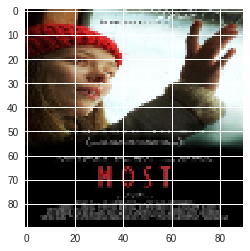

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(image)

### Images read and array stacking

##### READ IMAGES TRAINING SET

In [13]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

# READ IMAGES TRAINING SET
images_training = []
for i in tqdm(dataTraining.index):
  image = io.imread(os.path.join('/content/.kaggle/competitions/miia4406-movie-genre-classification/images/images', str(i) + '.jpeg'))
  image = resize(image,(90, 90, 3))
  images_training.append(image)
    


  0%|          | 0/7895 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
 14%|█▎        | 1081/7895 [01:34<09:55, 11.44it/s]

100%|██████████| 7895/7895 [11:03<00:00, 11.89it/s]


In [0]:
images_training = np.stack(images_training)

##### READ IMAGES TESTING SET

In [15]:
# READ IMAGES TESTING SET
images_testing = []
for i in tqdm(dataTesting.index):
  image = io.imread(os.path.join('/content/.kaggle/competitions/miia4406-movie-genre-classification/images/images', str(i) + '.jpeg'))
  image = resize(image,(90, 90, 3))
  images_testing.append(image)

  0%|          | 0/3383 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
 35%|███▌      | 1197/3383 [01:41<03:05, 11.80it/s]

100%|██████████| 3383/3383 [04:59<00:00, 11.30it/s]


In [16]:
images_testing = np.stack(images_testing)

images_testing.shape, dataTesting.shape[0]

((3383, 90, 90, 3), 3383)

### Create y

In [0]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [18]:
y_genres.shape

(7895, 24)

#IMAGES MODEL (DEEP LEARNING)

### Train and test split (For images)

In [0]:
X_train_img, X_test_img, y_train_genres_img, y_test_genres_img = train_test_split(images_training, y_genres, test_size=0.25)

## Neural network model

In [0]:
##modelo propuesto
input_shape= (90, 90, 3) 
num_class=24

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# layer 2
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
	# layer 3
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
	# layer 4
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
	# layer 5
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
	# layer 6
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
  # layer 7
model.add(Dense(num_class))
model.add(Activation('sigmoid'))
  #Compile
model.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])


In [22]:
# Fit the model 2 Epochs
model.fit(X_train_img, y_train_genres_img, epochs=2,validation_data=(X_test_img, y_test_genres_img))

y_pred_genres = model.predict_proba(X_test_img)
print(roc_auc_score(y_test_genres_img, y_pred_genres, average='macro'))

Train on 5921 samples, validate on 1974 samples
Epoch 1/2
5921/5921 [==============================] - 81s 14ms/step - loss: 0.2600 - acc: 0.8982 - val_loss: 0.2856 - val_acc: 0.8927
Epoch 2/2
5921/5921 [==============================] - 81s 14ms/step - loss: 0.2548 - acc: 0.9000 - val_loss: 0.2901 - val_acc: 0.8908
0.6062430544624441


# TEXT (DEEP LEARNING)

### Import and vectorize

In [0]:
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split

import io

In [105]:
import nltk
nltk.download('wordnet') #Download package for using in CoLab

X_train = dataTraining['plot']


from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

#Definition of function used for lemmatize
def split_into_lemmas(text):
    text = text.lower()
    words = text.split()
    return [wordnet_lemmatizer.lemmatize(word) for word in words]

#Use CountVectorizer to create document-term matrices from X
vect = CountVectorizer(lowercase=False,#Does not convert characters to lowercase
                      ngram_range=(1, 3), # include n-grams 
                      stop_words='english',
                      max_features=100000,
                      analyzer=split_into_lemmas #lemmas
                      )

X_dtm = vect.fit_transform(X_train)
print(X_dtm.shape)

[nltk_data] Downloading package wordnet to /content/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
(7895, 34629)


### Train and test split (For Text)

In [0]:
X_train_txt, X_test_txt, y_train_genres_txt, y_test_genres_txt = train_test_split(X_dtm, y_genres, test_size=0.25)

## NEURAL NETWORK MODEL

In [107]:
modelTxt = Sequential()

modelTxt.add(Dense(254, activation='relu',input_shape = X_dtm.shape[1:]))
modelTxt.add(Dropout(0.5))
modelTxt.add(Dense(24, activation='sigmoid'))

modelTxt.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
modelTxt.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 254)               8796020   
_________________________________________________________________
dropout_40 (Dropout)         (None, 254)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 24)                6120      
Total params: 8,802,140
Trainable params: 8,802,140
Non-trainable params: 0
_________________________________________________________________


In [108]:
#Fit model with 10 epochs
modelTxt.fit(X_train_txt, y_train_genres_txt, epochs=10,batch_size=16,verbose=1,validation_data=(X_test_txt, y_test_genres_txt))
y_pred_genres_txt = modelTxt.predict_proba(X_test_txt)
roc_auc_score(y_test_genres_txt, y_pred_genres_txt, average='macro')

Train on 5921 samples, validate on 1974 samples
Epoch 1/10
5921/5921 [==============================] - 10s 2ms/step - loss: 7.1312 - acc: 0.1971 - val_loss: 6.3585 - val_acc: 0.2052
Epoch 2/10
5921/5921 [==============================] - 8s 1ms/step - loss: 5.7431 - acc: 0.1966 - val_loss: 5.9151 - val_acc: 0.2031
Epoch 3/10
5584/5921 [===========================>..] - ETA: 0s - loss: 4.8940 - acc: 0.3213

5921/5921 [==============================] - 8s 1ms/step - loss: 4.8797 - acc: 0.3238 - val_loss: 5.8614 - val_acc: 0.3191
Epoch 4/10
5921/5921 [==============================] - 8s 1ms/step - loss: 4.3422 - acc: 0.4325 - val_loss: 5.8950 - val_acc: 0.3739
Epoch 5/10
5921/5921 [==============================] - 8s 1ms/step - loss: 4.0086 - acc: 0.4572 - val_loss: 6.1506 - val_acc: 0.3389
Epoch 6/10
2800/5921 [=============>................] - ETA: 3s - loss: 3.8440 - acc: 0.4682

5921/5921 [==============================] - 8s 1ms/step - loss: 3.7951 - acc: 0.4717 - val_loss: 6.1201 - val_acc: 0.3430
Epoch 7/10
5921/5921 [==============================] - 8s 1ms/step - loss: 3.6568 - acc: 0.4739 - val_loss: 6.2445 - val_acc: 0.3349
Epoch 8/10
5921/5921 [==============================] - 8s 1ms/step - loss: 3.5419 - acc: 0.4862 - val_loss: 6.4810 - val_acc: 0.3642
Epoch 9/10
2320/5921 [==========>...................] - ETA: 4s - loss: 3.5077 - acc: 0.4862

5921/5921 [==============================] - 8s 1ms/step - loss: 3.4829 - acc: 0.4842 - val_loss: 6.6327 - val_acc: 0.3571
Epoch 10/10
5921/5921 [==============================] - 8s 1ms/step - loss: 3.4202 - acc: 0.4778 - val_loss: 6.7199 - val_acc: 0.3217


0.8776462943260785

# Train multi-class multi-label models (Machine learning)

In [109]:
X_train.shape
y_train_genres

(7895,)

In [0]:
#:::IMAGES:::#

clfImg = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=200, max_depth=10))
clfImg.fit(X_train_img, y_train_genres_img)

y_pred_genres_img_ML = clfImg.predict_proba(X_test_img)

print(roc_auc_score(y_test_genres_img, y_pred_genres_img_ML, average='macro'))

In [0]:
#:::TEXT:::#
clfTxt = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10))
clfTxt.fit(X_train_txt, y_train_genres_txt)

y_pred_genres_txt_ML = clf.predict_proba(X_test_txt)

print("txt Acc = ",roc_auc_score(y_test_genres_txt, y_pred_genres_txt_ML, average='macro'))

# Apply models to kaggle test

In [0]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

X_test_dtm = vect.transform(dataTesting['plot'])


### MACHINE LEARNING

In [0]:
#::::IMAGES::::#
#Apply multi-class multi-label model to kaggle test set
y_pred_test_genres_img_ML = clf.predict_proba(images_testing)

#::::TEXT::::#
#Apply multi-class multi-label model to kaggle test set
y_pred_test_genres_txt_ML = clf.predict_proba(X_test_dtm)


### DEEP LEARNING

In [0]:
#::::IMAGES::::Apply Deep model to kaggle test set
X_test_genres_img_DL = model_vgg16.predict(images_testing)
y_pred_test_genres_img_DL = model.predict_proba(X_test_genres_img_DL)


In [0]:
#::::TEXT::::Apply Deep model to kaggle test set
y_pred_test_genres_txt_DL = modelTxt.predict_proba(X_test_dtm)





# MODELS COMBINATION 

### MACHINE LEARNING

In [0]:
#Then weighted average is calculated to obtain each probabilitie for MACHINE LEARNING MODELS
finalResultsML = y_pred_test_genres_img_ML*w_img + y_pred_test_genres_txt_ML*w_txt
print (finalResultsML)
pd.DataFrame(finalResultsML, index=dataTesting.index, columns=cols).to_csv('FP_ML.csv', index_label='ID')

In [0]:
!kaggle competitions submit -c miia4406-movie-genre-classification -f FP_ML.csv -m "FINAL WITH MACHINE LEARNING"

### DEEP LEARNING

In [0]:
y_pred_test_genres_img_DL = np.array(y_pred_test_genres_img_DL)
y_pred_test_genres_txt_DL = np.array(y_pred_test_genres_txt_DL)

In [104]:
print(y_pred_test_genres_img_DL.shape,y_pred_test_genres_img_DL.dtype)
print(y_pred_test_genres_txt_DL.shape,y_pred_test_genres_txt_DL.dtype)

(3383, 24) float32
(3383, 24) float32


In [125]:
#weights are assigned for each model
w_img = 0.002
w_txt = 1-w_img

#Then weighted average is calculated to obtain each probabilitie for DEEP MODELS
finalResultsDL = w_img*y_pred_test_genres_img_DL + w_txt*y_pred_test_genres_txt_DL

print (finalResultsDL)

#create csv
pd.DataFrame(finalResultsDL, index=dataTesting.index, columns=cols).to_csv('FP_DL.csv', index_label='ID')

[[2.02579405e-02 4.72591491e-03 3.18890176e-04 ... 7.00241551e-02
  7.87152909e-04 6.64637890e-04]
 [4.90080006e-02 1.79138163e-03 6.84037455e-04 ... 4.32073504e-01
  1.02146412e-03 4.32320288e-04]
 [1.09416689e-03 7.68909638e-04 1.05762265e-04 ... 9.98880863e-01
  2.47651857e-04 1.33223948e-04]
 ...
 [2.40550586e-03 1.96793955e-03 1.90236233e-02 ... 1.90092833e-03
  3.93418333e-04 2.99320614e-04]
 [1.41754728e-02 8.20361793e-01 6.86604604e-02 ... 2.29662564e-03
  7.01972051e-04 3.29124596e-04]
 [2.02094503e-02 3.54105346e-02 7.45067820e-02 ... 3.62583511e-02
  6.29153044e-04 4.33981593e-04]]


In [0]:
files.download('FP_DL.csv')

In [122]:
#submit results to competition
!kaggle competitions submit -c miia4406-movie-genre-classification -f FP_DL.csv -m "FINAL DEEP LEARNING"

503 - Service Unavailable


In [0]:
#!kaggle competitions submit -c miia4406-movie-genre-classification -f FP_DL.csv -m "FINAL WITH DEEP LEARNING"